# Temporal Siries

Project repository for the time series course at the cin ufpe postgraduate course


# Libraries import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error

2022-12-20 21:07:43.934034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 21:07:44.043117: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 21:07:44.474420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-20 21:07:44.474487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Exploring Data

In [2]:
generation_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_1_Weather_Sensor_Data.csv')
generation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


## Data time changing, merging and checking for null data

In [3]:
generation_data['DATE_TIME'] = pd.to_datetime(generation_data["DATE_TIME"])
weather_data['DATE_TIME'] = pd.to_datetime(weather_data["DATE_TIME"])

df = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df.isnull().sum()
#%%

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

## Plotting correlations

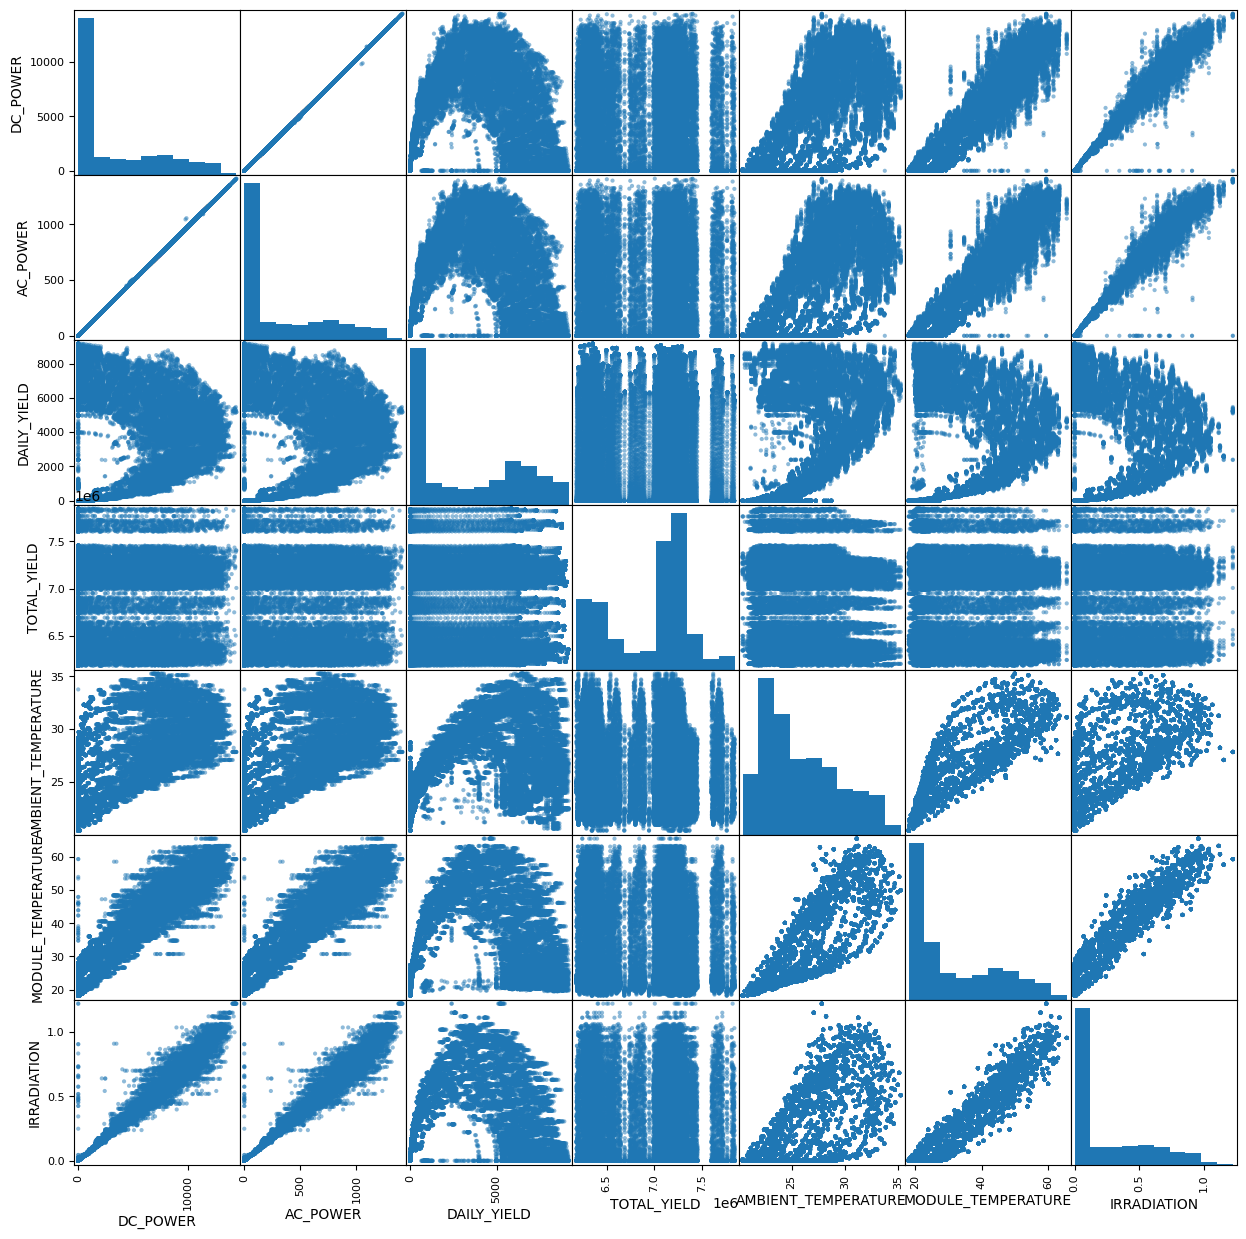

In [4]:
pd.plotting.scatter_matrix(df, figsize=(15,15))

plt.show()

In [5]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DC_POWER,1.000000,0.999996,0.076710,0.004055,0.703796,0.954692,0.991305
AC_POWER,0.999996,1.000000,0.076628,0.004043,0.704035,0.954810,0.991260
DAILY_YIELD,0.076710,0.076628,1.000000,0.007277,0.489709,0.203702,0.071937
TOTAL_YIELD,0.004055,0.004043,0.007277,1.000000,-0.036532,-0.014713,-0.004981
AMBIENT_TEMPERATURE,0.703796,0.704035,0.489709,-0.036532,1.000000,0.843456,0.702218
MODULE_TEMPERATURE,0.954692,0.954810,0.203702,-0.014713,0.843456,1.000000,0.959346
IRRADIATION,0.991305,0.991260,0.071937,-0.004981,0.702218,0.959346,1.000000


With that, we can see that irradiation and module_temperature are very correlate to the AC power generated. These will be the two main components for prediction. But is still important to use the ambient temperature in some of the experiments because it is the easier data to get in any solar power forecasting. So for this work we will try to predict AC power using ambient temperature and irradiation

## Some data analysis

In [6]:
encoder = LabelEncoder()
df['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df['SOURCE_KEY'])
print(df['SOURCE_KEY_NUMBER'].nunique())

22


Is important to notice that in this dataset we have 22 individual solar panels.

### Analyzing the behavior of one of the painels

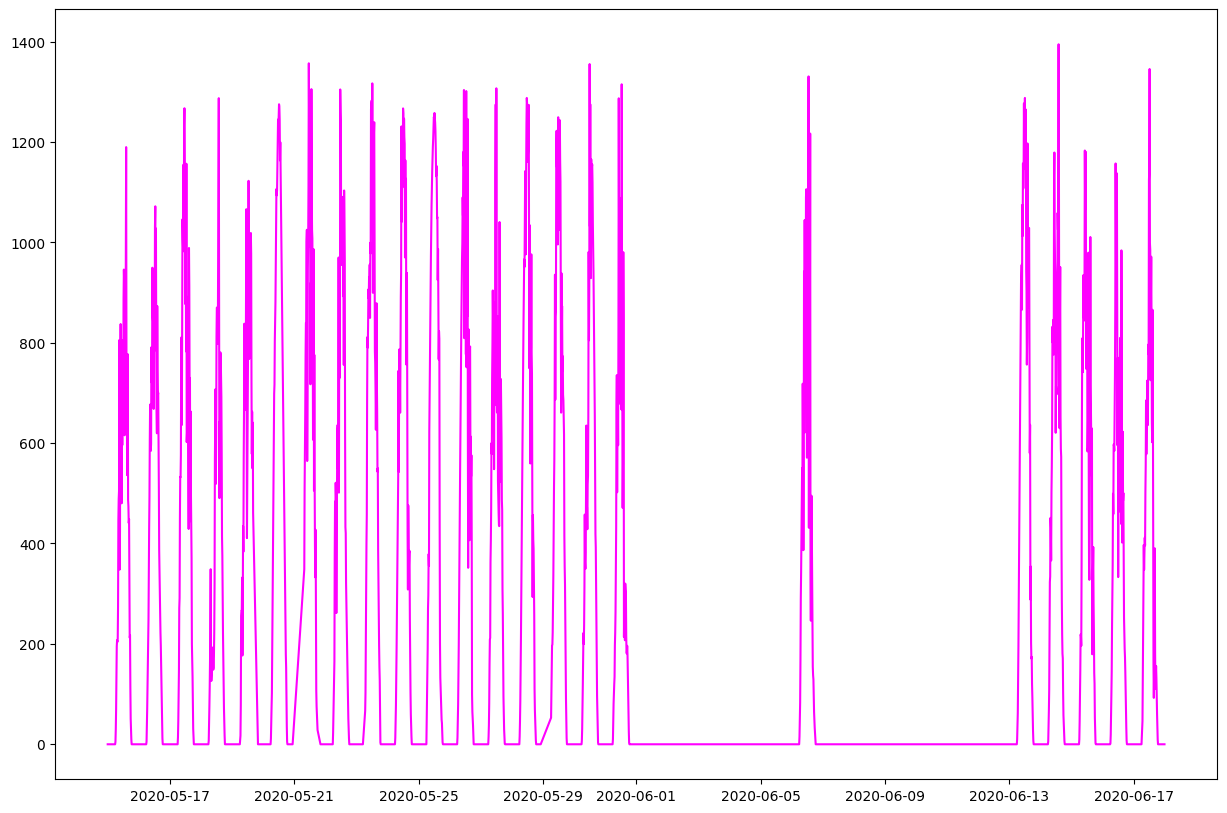

In [7]:
colors = ['olive', 'crimson', 'maroon', 'fuchsia']
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 1]
df1 = df1.reset_index()

plt.figure(figsize=(15,10))
plt.plot( df1['DATE_TIME'],df1['AC_POWER'],color =colors[3],linestyle = 'solid')
plt.show()


The interval without data occurs on account of this command df = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME', executed early

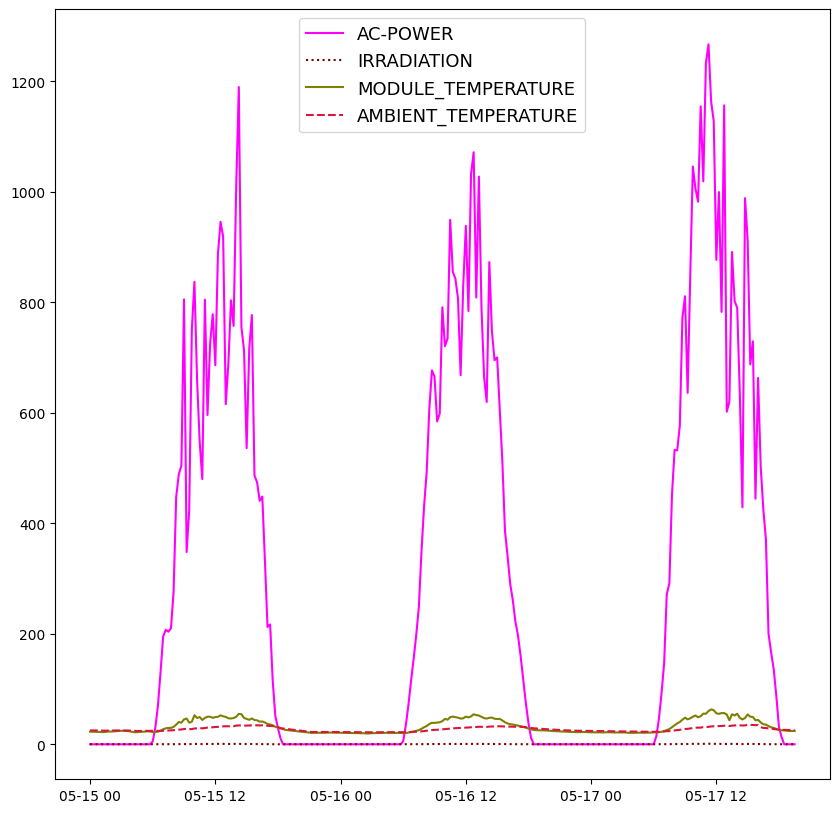

In [8]:
plt.figure(figsize=(10,10))
plt.plot( df1['DATE_TIME'][0:250],df1['AC_POWER'][0:250],color =colors[3],linestyle = '-')
plt.plot( df1['DATE_TIME'][0:250],df1['IRRADIATION'][0:250],color =colors[2],linestyle = ':')
plt.plot( df1['DATE_TIME'][0:250],df1['MODULE_TEMPERATURE'][0:250],color =colors[0],linestyle = '-')
plt.plot( df1['DATE_TIME'][0:250],df1['AMBIENT_TEMPERATURE'][0:250],color =colors[1],linestyle = '--')
plt.legend(('AC-POWER',
           'IRRADIATION',
           'MODULE_TEMPERATURE',
           'AMBIENT_TEMPERATURE'),fontsize=13)
plt.show()


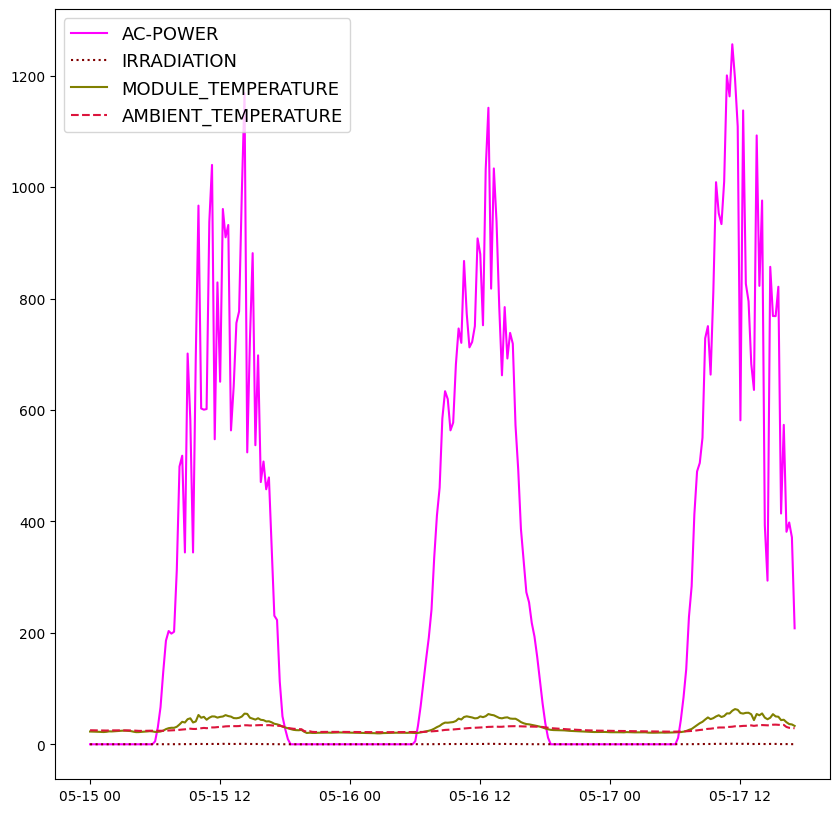

In [9]:
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 19]
df1 = df1.reset_index()

plt.figure(figsize=(10,10))
plt.plot( df1['DATE_TIME'][0:250],df1['AC_POWER'][0:250],color =colors[3],linestyle = '-')
plt.plot( df1['DATE_TIME'][0:250],df1['IRRADIATION'][0:250],color =colors[2],linestyle = ':')
plt.plot( df1['DATE_TIME'][0:250],df1['MODULE_TEMPERATURE'][0:250],color =colors[0],linestyle = '-')
plt.plot( df1['DATE_TIME'][0:250],df1['AMBIENT_TEMPERATURE'][0:250],color =colors[1],linestyle = '--')
plt.legend(('AC-POWER',
           'IRRADIATION',
           'MODULE_TEMPERATURE',
           'AMBIENT_TEMPERATURE'),fontsize=13)
plt.show()

The scale of the data is very different, lets normalize it and use only the variables we will work on.

In [10]:
mean_irradiation = df['IRRADIATION'].mean()
std_irradiation = df['IRRADIATION'].std()
mean_ac = df['AC_POWER'].mean()
std_ac = df['AC_POWER'].std()  
mean_temp = df['AMBIENT_TEMPERATURE'].mean()
std_temp = df['AMBIENT_TEMPERATURE'].std()  
df['AC_POWER']=(df['AC_POWER']-df['AC_POWER'].mean())/df['AC_POWER'].std()
df['IRRADIATION']=(df['IRRADIATION']-df['IRRADIATION'].mean())/df['IRRADIATION'].std()
df['AMBIENT_TEMPERATURE']=(df['AMBIENT_TEMPERATURE']-df['AMBIENT_TEMPERATURE'].mean())/df['AMBIENT_TEMPERATURE'].std()

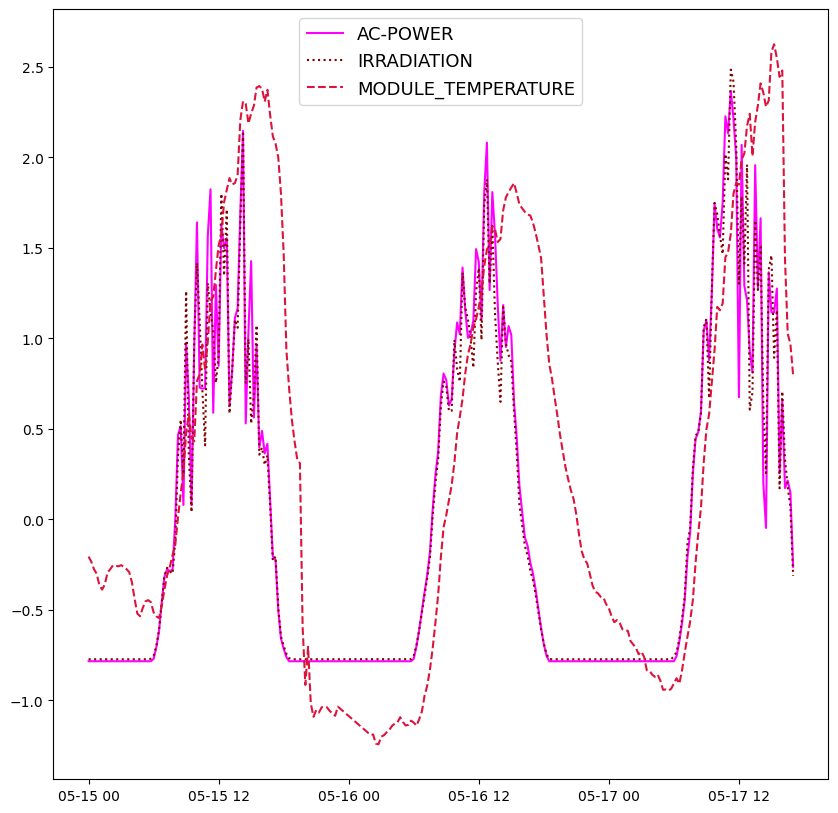

In [11]:
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 19]
df1 = df1.reset_index()

plt.figure(figsize=(10,10))
plt.plot( df1['DATE_TIME'][0:250],df1['AC_POWER'][0:250],color =colors[3],linestyle = '-')
plt.plot( df1['DATE_TIME'][0:250],df1['IRRADIATION'][0:250],color =colors[2],linestyle = ':')
plt.plot( df1['DATE_TIME'][0:250],df1['AMBIENT_TEMPERATURE'][0:250],color =colors[1],linestyle = '--')
plt.legend(('AC-POWER',
           'IRRADIATION',
           'MODULE_TEMPERATURE',
           'AMBIENT_TEMPERATURE'),fontsize=13)
plt.show()

Every solar panel have similar data, but with natural distiction.

In [12]:
len(df1)

2075

We have 2075 diffent points, so we can divide later the dataset into 

# Experiment with IRRADIATION 15 min pred

## Preper data for training

In [13]:
#Function to split one variable time series sequences
def split_sequence(sequence_x1, sequence_y, n_steps):
    X, y = list(), list()

    for i in range(len(sequence_x1)):
		# find the end of this pattern
        end_ix = i + n_steps
		# check if we are beyond the sequence
        if end_ix > len(sequence_x1)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence_x1[i:end_ix], sequence_y[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#Function to create series
def creates_series(series_x1, series_y, n_steps,split_size):
    X1 = series_x1.values
    Y = series_y.values
    train_x1, test_x1 = X1[0:split_size], X1[split_size:]
    train_y, test_y = Y[0:split_size], Y[split_size:]
    X_train, y_train = split_sequence(train_x1,train_y, n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape((y_train.shape[0], 1))
    return X_train, y_train, train_x1 ,test_x1, train_y, test_y

def make_dataset(df, tag_x, tag_y,num_painels, n_steps, split_size):
    for i in range (num_painels):
        df1 = df.loc[df['SOURCE_KEY_NUMBER'] == i]
        df1 = df1.reset_index()
        X = df1[tag_x]
        y = df1[tag_y]
        X_train1, y_train1, train_x1 ,test_x1, train_y, test_y = creates_series(X,y ,n_steps,split_size)
        if i == 0:
            X_train = X_train1
            y_train =  y_train1
        else:
            X_train = np.concatenate((X_train,X_train1))
            y_train = np.concatenate((y_train,y_train1))
    return X_train, y_train

Creating training dataset

In [14]:
tag_x = 'IRRADIATION'
tag_y = 'AC_POWER'
num_painels = df['SOURCE_KEY_NUMBER'].nunique()
n_steps = 2
split_size = 1500
n_features = 1
X_train, y_train = make_dataset(df, tag_x, tag_y, num_painels, n_steps, split_size)
len(X_train)

32956

MLP model

In [15]:
model_mlp = Sequential()
model_mlp.add(Dense(1024, activation='relu', input_shape=(n_steps, 1)))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mae', optimizer='adam')
model_mlp.fit(X_train, y_train, epochs=15)

2022-12-20 21:07:53.461765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:07:53.486280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:07:53.486428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 21:07:53.486887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/15
1030/1030 [==============================] - 3s 2ms/step - loss: 0.1910
Epoch 2/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1834
Epoch 3/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1840
Epoch 4/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1831
Epoch 5/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1822
Epoch 6/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1815
Epoch 7/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1808
Epoch 8/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1809
Epoch 9/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1795
Epoch 10/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1795
Epoch 11/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1789
Epoch 12/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.1796
E

Stacked LSTM model

In [16]:
model_sLSTM = Sequential()
model_sLSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_sLSTM.add(LSTM(50, activation='relu'))
model_sLSTM.add(Dense(1))
model_sLSTM.compile(optimizer='adam', loss='mse')
model_sLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
1030/1030 [==============================] - 7s 6ms/step - loss: 0.1301
Epoch 2/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0833
Epoch 3/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0830
Epoch 4/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0827
Epoch 5/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0825
Epoch 6/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0823
Epoch 7/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0822
Epoch 8/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0820
Epoch 9/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0820
Epoch 10/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0818
Epoch 11/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0817
Epoch 12/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.0814
E

Bidirecional LSTM model

In [17]:
model_bLSTM = Sequential()
model_bLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model_bLSTM.add(Dense(1))
model_bLSTM.compile(optimizer='adam', loss='mse')
model_bLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
1030/1030 [==============================] - 7s 5ms/step - loss: 0.1135
Epoch 2/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0829
Epoch 3/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0827
Epoch 4/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0823
Epoch 5/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0825
Epoch 6/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0820
Epoch 7/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0820
Epoch 8/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0818
Epoch 9/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0819
Epoch 10/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0815
Epoch 11/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0814
Epoch 12/15
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0813
E

## Test

Function for test and plot

In [18]:
def error_and_plot(model,train_x,test_x,test_y,n_steps,n_features, split_size):
    history = []
    for i in range(n_steps):
        history.append(array(train_x[(split_size-n_steps)+i]))
    predictions = []
    for t in range(len(test_x)):
        input_vec = np.zeros([n_steps,1])
        for i in range (n_steps):
            input_vec[i] = history[i]
        
        input_vec = input_vec.reshape((1,n_steps,n_features))
        yhat = model.predict(input_vec, verbose = 0)
        predictions.append(yhat[0][0])
        history.append(test_x[t])
        history = history[-n_steps:]
        
    rmse = sqrt(mean_squared_error(test_y, predictions))
    mape = mean_absolute_percentage_error(test_y, predictions)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAPE: %.3f' % mape)
    # plot forecasts against actual outcomes
    plt.figure(figsize=(7,7))
    plt.plot(test_y,)
    plt.plot(predictions, color='red', linestyle = '--')

    plt.legend(('Real Value',
           'Prediction',
                ),fontsize=13)
    pyplot.show()

### Testing on same power plant dataset

In [19]:
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 1]
df1 = df1.reset_index()
n_features = 1
y1 = df1['AC_POWER']
X1 = df1['IRRADIATION']
X_train1, y_train1, train_x1 ,test_x1, train_y1, test_y1 = creates_series(X1,y1 ,n_steps,1500)

MLP

Test RMSE: 0.385
Test MAPE: 0.694


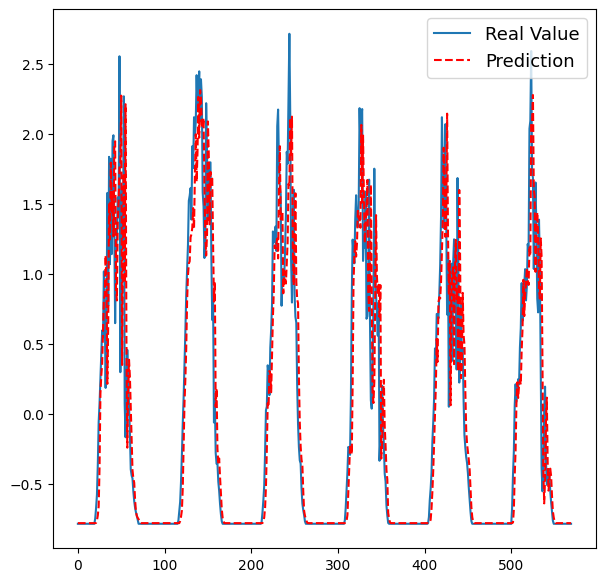

In [20]:
error_and_plot(model_mlp,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Stacked LSTM

Test RMSE: 0.291
Test MAPE: 0.419


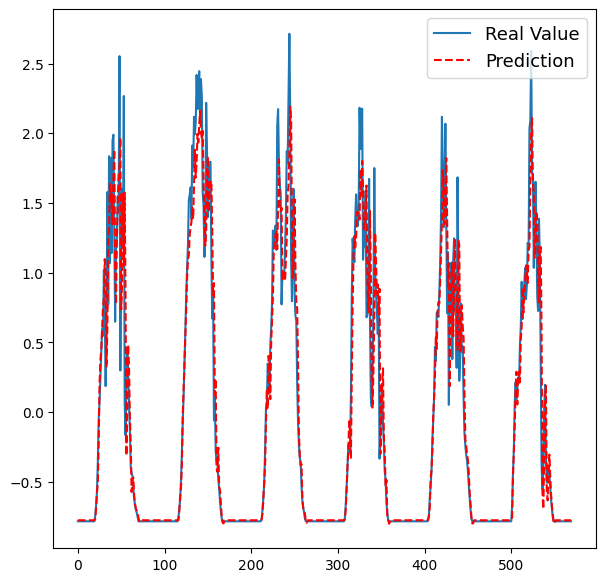

In [21]:
error_and_plot(model_sLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Bidirectional LSTM

Test RMSE: 0.290
Test MAPE: 0.423


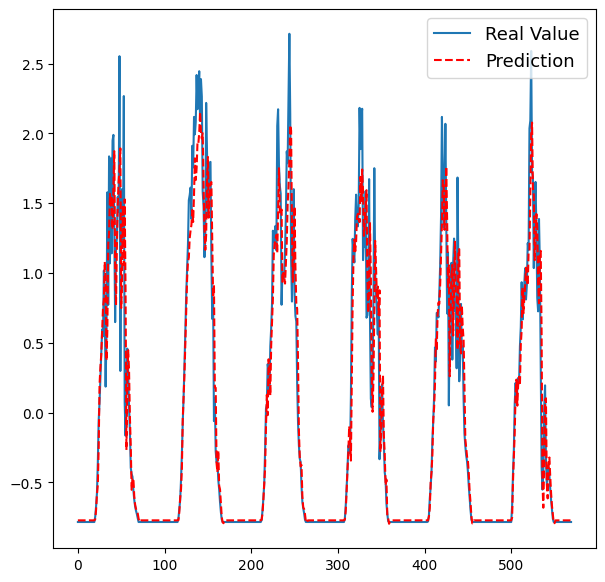

In [22]:
error_and_plot(model_bLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

### Testing for other power plant

In [23]:
generation_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_2_Weather_Sensor_Data.csv')
df_2 = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
encoder = LabelEncoder()
df_2['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_2['SOURCE_KEY'])
df_2['AC_POWER']=(df_2['AC_POWER']-mean_ac)/std_ac
df_2['IRRADIATION']=(df_2['IRRADIATION']-mean_irradiation)/std_irradiation


In [24]:
df1 = df_2.loc[df_2['SOURCE_KEY_NUMBER'] == 2]
df1 = df1.reset_index()
n_features = 1
y1 = df1['AC_POWER']
X1 = df1['IRRADIATION']
X_train1, y_train1, train_x1 ,test_x1, train_y1, test_y1 = creates_series(X1,y1 ,n_steps,1500)

MLP

Test RMSE: 0.768
Test MAPE: 1.930


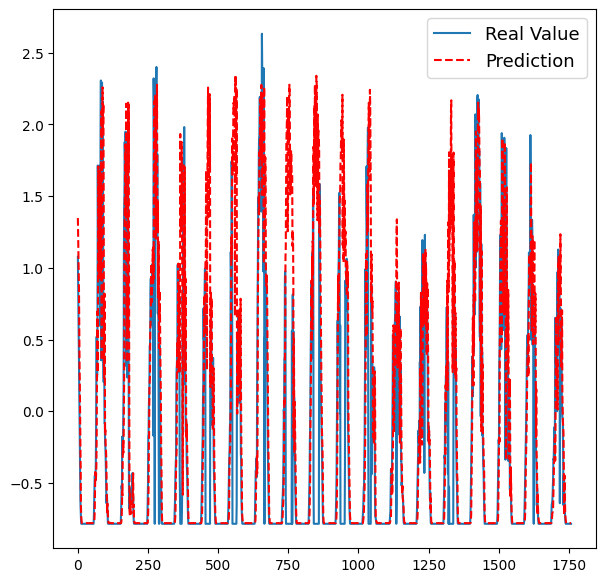

In [25]:
error_and_plot(model_mlp,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Stacked LSTM

Test RMSE: 0.720
Test MAPE: 1.490


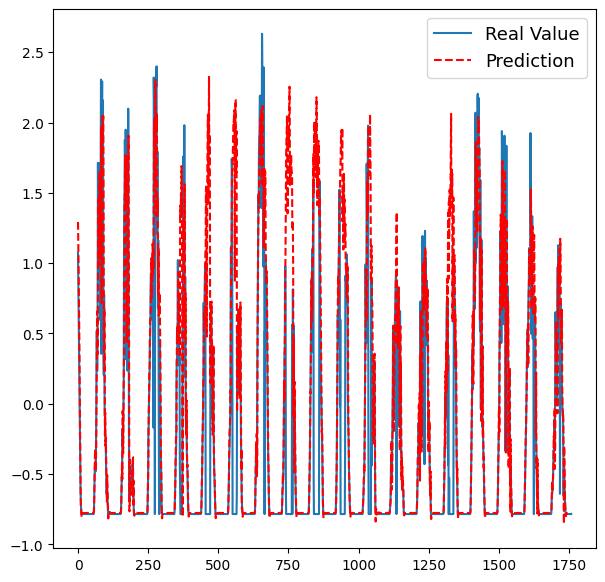

In [26]:
error_and_plot(model_sLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Bidirectional LSTM

Test RMSE: 0.712
Test MAPE: 1.470


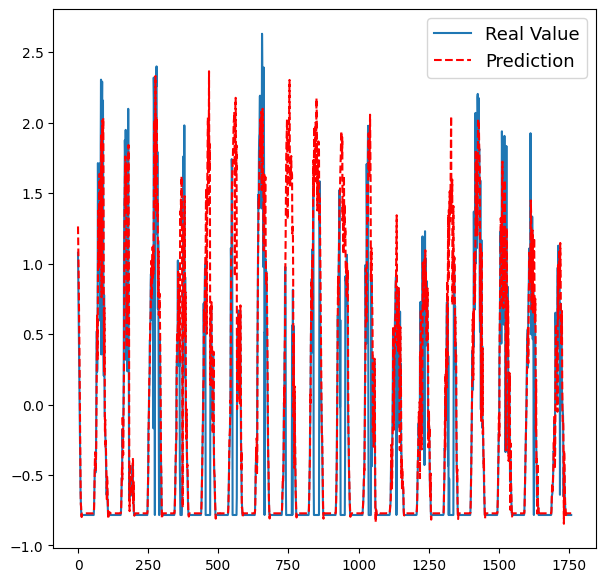

In [27]:
error_and_plot(model_bLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

# Experiment with AMBIENT_TEMPATURE 15 min pred

## Training

In [29]:
tag_x = 'AMBIENT_TEMPERATURE'
X_train, y_train = make_dataset(df, tag_x, tag_y, num_painels, n_steps, split_size)
len(X_train)

32956

MLP model

In [30]:
model_mlp = Sequential()
model_mlp.add(Dense(1024, activation='relu', input_shape=(n_steps, 1)))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mae', optimizer='adam')
model_mlp.fit(X_train, y_train, epochs=15)

Epoch 1/15
1030/1030 [==============================] - 3s 2ms/step - loss: 0.5601
Epoch 2/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5469
Epoch 3/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5443
Epoch 4/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5434
Epoch 5/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5423
Epoch 6/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5432
Epoch 7/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5409
Epoch 8/15
1030/1030 [==============================] - 2s 2ms/step - loss: 0.5408
Epoch 9/15
1030/1030 [==============================] - 3s 2ms/step - loss: 0.5406
Epoch 10/15
1030/1030 [==============================] - 3s 2ms/step - loss: 0.5402
Epoch 11/15
1030/1030 [==============================] - 3s 2ms/step - loss: 0.5404
Epoch 12/15
1030/1030 [==============================] - 3s 3ms/step - loss: 0.5405
E

Stacked LSTM model

In [31]:
model_sLSTM = Sequential()
model_sLSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_sLSTM.add(LSTM(50, activation='relu'))
model_sLSTM.add(Dense(1))
model_sLSTM.compile(optimizer='adam', loss='mse')
model_sLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
1030/1030 [==============================] - 8s 6ms/step - loss: 0.5226
Epoch 2/15
1030/1030 [==============================] - 7s 6ms/step - loss: 0.2860
Epoch 3/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2625
Epoch 4/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2553
Epoch 5/15
1030/1030 [==============================] - 7s 7ms/step - loss: 0.2488
Epoch 6/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2451
Epoch 7/15
1030/1030 [==============================] - 7s 7ms/step - loss: 0.2405
Epoch 8/15
1030/1030 [==============================] - 7s 6ms/step - loss: 0.2403
Epoch 9/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2389
Epoch 10/15
1030/1030 [==============================] - 7s 7ms/step - loss: 0.2379
Epoch 11/15
1030/1030 [==============================] - 7s 7ms/step - loss: 0.2358
Epoch 12/15
1030/1030 [==============================] - 7s 7ms/step - loss: 0.2376
E

Bidirecional LSTM model

In [32]:
model_bLSTM = Sequential()
model_bLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model_bLSTM.add(Dense(1))
model_bLSTM.compile(optimizer='adam', loss='mse')
model_bLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
1030/1030 [==============================] - 7s 6ms/step - loss: 0.5488
Epoch 2/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.3789
Epoch 3/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.3428
Epoch 4/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.3100
Epoch 5/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2934
Epoch 6/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2893
Epoch 7/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2865
Epoch 8/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2847
Epoch 9/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2842
Epoch 10/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2812
Epoch 11/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2826
Epoch 12/15
1030/1030 [==============================] - 6s 6ms/step - loss: 0.2827
E

## Test

### Testing on same power plant dataset

In [38]:
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 1]
df1 = df1.reset_index()
n_features = 1
y1 = df1['AC_POWER']
X1 = df1['AMBIENT_TEMPERATURE']
X_train1, y_train1, train_x1 ,test_x1, train_y1, test_y1 = creates_series(X1,y1 ,n_steps,1500)

MLP

Test RMSE: 0.900
Test MAPE: 1.144


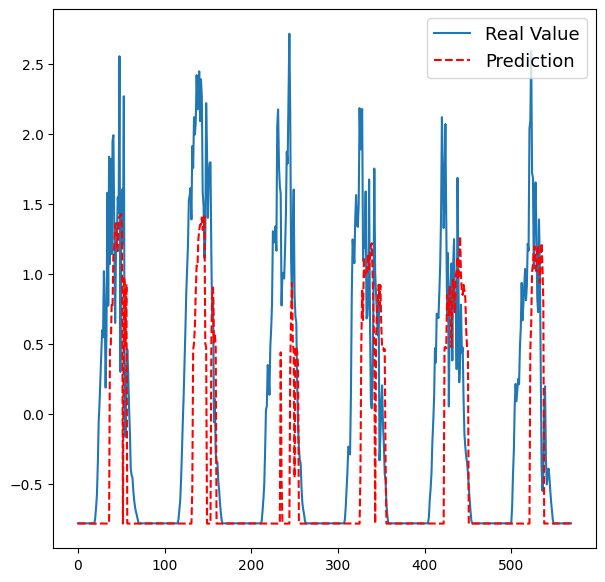

In [39]:
error_and_plot(model_mlp,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Stacked LSTM

Test RMSE: 0.642
Test MAPE: 0.863


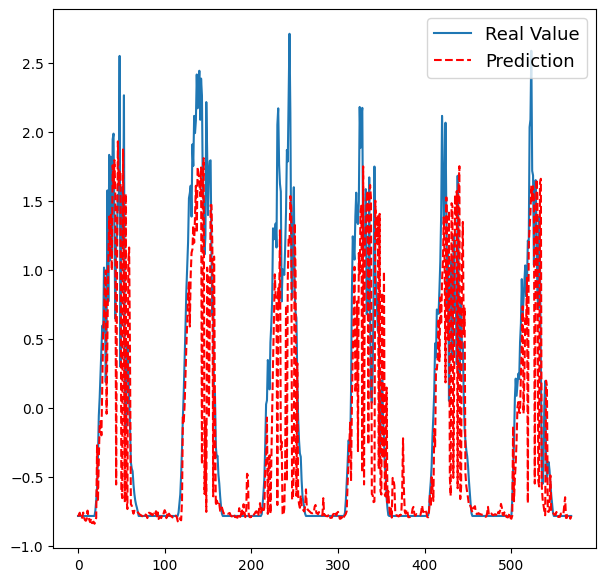

In [40]:
error_and_plot(model_sLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Bidirectional LSTM

Test RMSE: 0.696
Test MAPE: 0.803


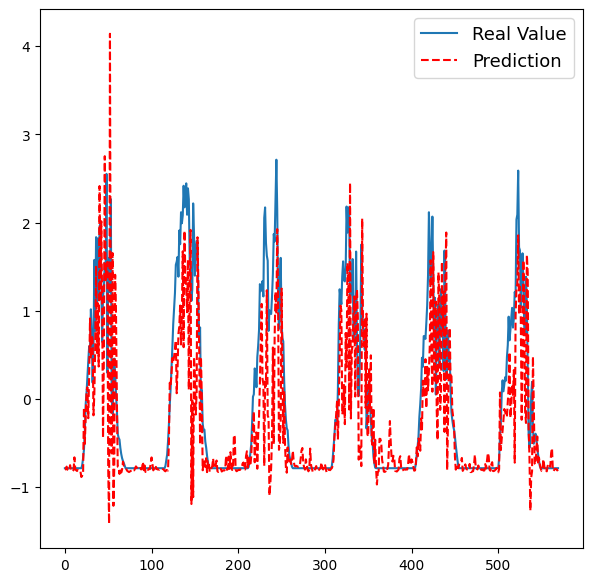

In [41]:
error_and_plot(model_bLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

### Testing for other power plant

In [42]:
generation_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('/home/pauloguedes/series-temporais/datasets/kaggle/Plant_2_Weather_Sensor_Data.csv')
df_2 = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
encoder = LabelEncoder()
df_2['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_2['SOURCE_KEY'])
df_2['AC_POWER']=(df_2['AC_POWER']-mean_ac)/std_ac
df_2['AMBIENT_TEMPERATURE']=(df_2['AMBIENT_TEMPERATURE']-mean_temp)/std_temp


In [43]:
df1 = df_2.loc[df_2['SOURCE_KEY_NUMBER'] == 2]
df1 = df1.reset_index()
n_features = 1
y1 = df1['AC_POWER']
X1 = df1['AMBIENT_TEMPERATURE']
X_train1, y_train1, train_x1 ,test_x1, train_y1, test_y1 = creates_series(X1,y1 ,n_steps,1500)

MLP

Test RMSE: 0.935
Test MAPE: 3.762


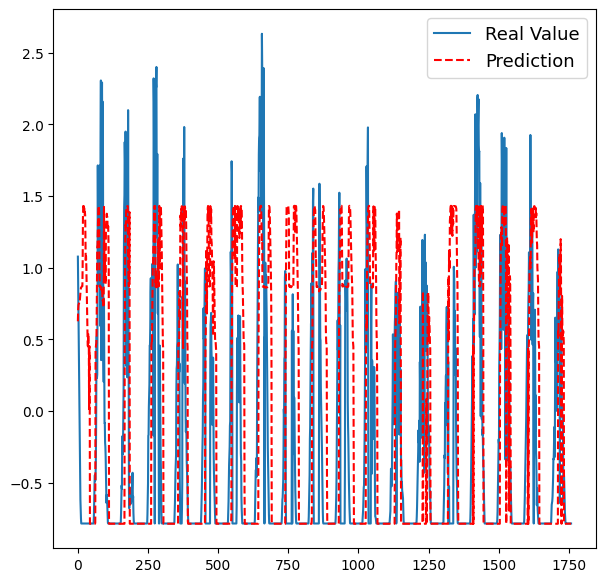

In [44]:
error_and_plot(model_mlp,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Stacked LSTM

Test RMSE: 0.845
Test MAPE: 1.651


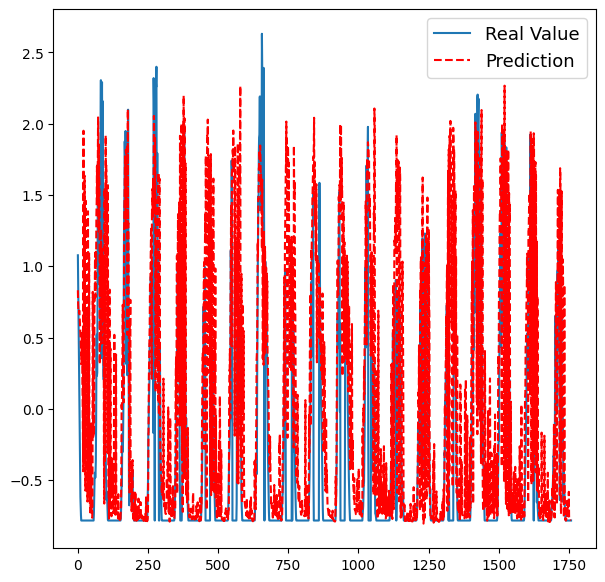

In [45]:
error_and_plot(model_sLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Bidirectional LSTM

Test RMSE: 0.897
Test MAPE: 1.590


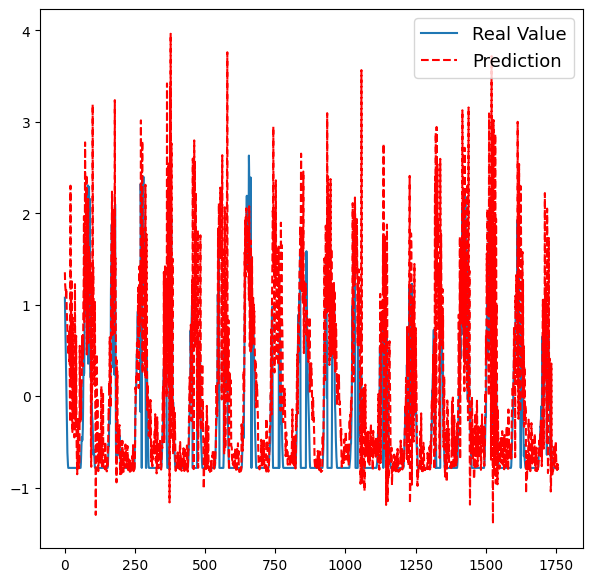

In [46]:
error_and_plot(model_bLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

# Experiment with IRRADIANCE 1h pred

## Training

In [77]:
def make_dataset_1h(df, tag_x, tag_y,num_painels, n_steps, split_size):
    for i in range (num_painels):
        df1 = df.loc[df['SOURCE_KEY_NUMBER'] == i]
        df1 = df1.reset_index()
        df1 = df1.iloc[::4]
        df1 = df1.reset_index()
        X = df1[tag_x]
        y = df1[tag_y]
        X_train1, y_train1, train_x1 ,test_x1, train_y, test_y = creates_series(X,y ,n_steps,split_size)
        if i == 0:
            X_train = X_train1
            y_train =  y_train1
        else:
            X_train = np.concatenate((X_train,X_train1))
            y_train = np.concatenate((y_train,y_train1))
    return X_train, y_train

In [82]:
tag_x = 'IRRADIATION'
n_steps = 2
split_size = 375
X_train, y_train = make_dataset_1h(df, tag_x, tag_y, num_painels, n_steps, split_size)
len(X_train)

8206

MLP model

In [83]:
model_mlp = Sequential()
model_mlp.add(Dense(1024, activation='relu', input_shape=(n_steps, 1)))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mae', optimizer='adam')
model_mlp.fit(X_train, y_train, epochs=15)

Epoch 1/15
257/257 [==============================] - 1s 2ms/step - loss: 0.4116
Epoch 2/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3936
Epoch 3/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3930
Epoch 4/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3936
Epoch 5/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3934
Epoch 6/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3925
Epoch 7/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3926
Epoch 8/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3924
Epoch 9/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3907
Epoch 10/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3910
Epoch 11/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3904
Epoch 12/15
257/257 [==============================] - 1s 2ms/step - loss: 0.3907
Epoch 13/15
257/257 [====

Stacked LSTM model

In [84]:
model_sLSTM = Sequential()
model_sLSTM.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_sLSTM.add(LSTM(50, activation='relu'))
model_sLSTM.add(Dense(1))
model_sLSTM.compile(optimizer='adam', loss='mse')
model_sLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
257/257 [==============================] - 3s 6ms/step - loss: 0.4116
Epoch 2/15
257/257 [==============================] - 2s 6ms/step - loss: 0.2057
Epoch 3/15
257/257 [==============================] - 2s 6ms/step - loss: 0.2010
Epoch 4/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1965
Epoch 5/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1945
Epoch 6/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1931
Epoch 7/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1903
Epoch 8/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1902
Epoch 9/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1885
Epoch 10/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1872
Epoch 11/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1864
Epoch 12/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1859
Epoch 13/15
257/257 [====

Bidirecional LSTM model

In [85]:
model_bLSTM = Sequential()
model_bLSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model_bLSTM.add(Dense(1))
model_bLSTM.compile(optimizer='adam', loss='mse')
model_bLSTM.fit(X_train, y_train, epochs=15)

Epoch 1/15
257/257 [==============================] - 3s 6ms/step - loss: 0.3874
Epoch 2/15
257/257 [==============================] - 2s 6ms/step - loss: 0.2108
Epoch 3/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1943
Epoch 4/15
257/257 [==============================] - 1s 6ms/step - loss: 0.1910
Epoch 5/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1896
Epoch 6/15
257/257 [==============================] - 2s 7ms/step - loss: 0.1887
Epoch 7/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1875
Epoch 8/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1863
Epoch 9/15
257/257 [==============================] - 2s 8ms/step - loss: 0.1865
Epoch 10/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1860
Epoch 11/15
257/257 [==============================] - 1s 6ms/step - loss: 0.1855
Epoch 12/15
257/257 [==============================] - 2s 6ms/step - loss: 0.1847
Epoch 13/15
257/257 [====

## Test

Testing on same power plant dataset

In [87]:
df1 = df.loc[df['SOURCE_KEY_NUMBER'] == 1]
df1 = df1.reset_index()
df1 = df1.iloc[::4]
df1 = df1.reset_index()
n_features = 1
y1 = df1['AC_POWER']
X1 = df1['IRRADIATION']
X_train1, y_train1, train_x1 ,test_x1, train_y1, test_y1 = creates_series(X1,y1 ,n_steps,split_size)

MLP

Test RMSE: 0.727
Test MAPE: 1.237


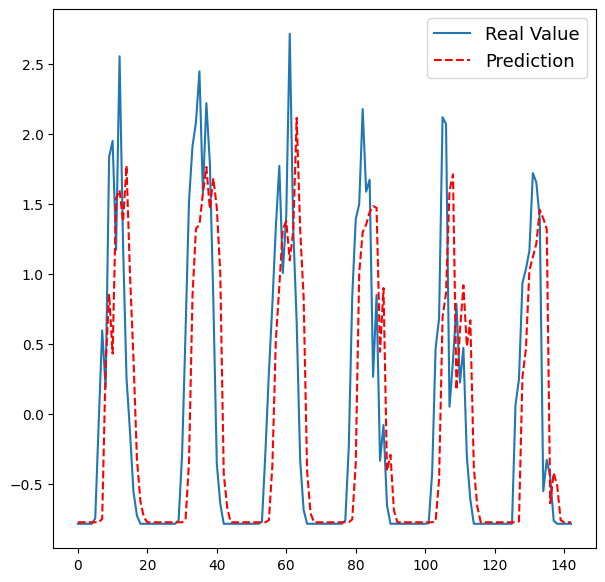

In [88]:
error_and_plot(model_mlp,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Stacked LSTM

Test RMSE: 0.504
Test MAPE: 0.879


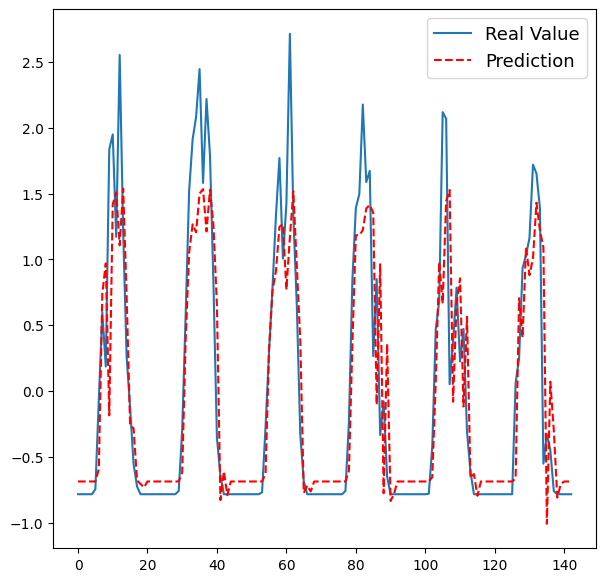

In [89]:
error_and_plot(model_sLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)

Bidirectional LSTM

Test RMSE: 0.499
Test MAPE: 0.876


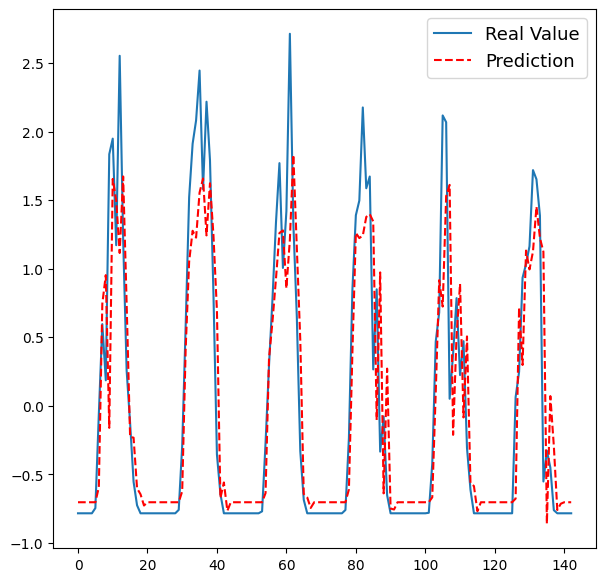

In [90]:
error_and_plot(model_bLSTM,train_x1,test_x1,test_y1,n_steps,n_features, split_size)